In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [3]:
def jsonToEmbeddingClouds(path):
  '''
  1. Traverses given directory
  2. finds json files
  3. parses them for their embeddings
  4. returns a list of all the embeddings
  '''
  embedding_cloud = []
  for root,dirs,files in os.walk(path):
    for file in files:
      if file.endswith('.json'):
        with open(root + '/' + file) as json_file:
          data = json.load(json_file)
          embedding = data['embedding']
          embedding_cloud.append(embedding[0])
  return embedding_cloud

Class, Method, and Token Counts

In [ ]:
class_cloud = jsonToEmbeddingClouds('./data/ivyClass')
len(class_cloud)

768

In [ ]:
method_cloud = jsonToEmbeddingClouds('./data/ivyMethod')
len(method_cloud)

In [ ]:
token_cloud = jsonToEmbeddingClouds('./data/ivyToken')
len(token_cloud)

1.) Assess location by comparing the points to the origin—compute a histogram of the ℓ2 norms

In [6]:
def computeL2Norms(embedding_cloud, title):
  '''
  1. for each embedding in the cloud
  2. compute the l2 norm with numpy
  3. return a list of all the l2 norms
  4. compute the average
  5. plot a histogram of the l2 norms
  '''
  l2_norms = []
  for embedding in embedding_cloud:
    l2_norm = np.linalg.norm(embedding)
    l2_norms.append(l2_norm)

  avg = np.mean(l2_norms)
  std = np.std(l2_norms)


  plt.hist(l2_norms, bins = len(l2_norms), histtype='step', color=['blue'], fill=True, alpha=0.05)
  plt.axvline(avg, color='k', linestyle='dashed',linewidth=1)
  plt.axvline(avg+std, color='red', linestyle='dashed',linewidth=1)
  plt.axvline(avg-std, color='red', linestyle='dashed',linewidth=1)


  plt.title( '1. Ivy '+title + ' L^2-Norm Histogram')
  plt.show()

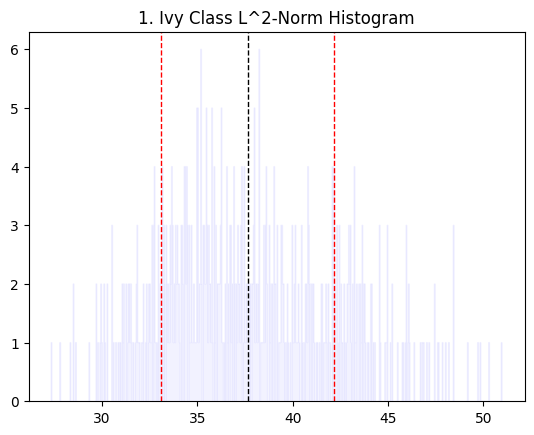

In [7]:
computeL2Norms(class_cloud, 'Class')

In [ ]:
computeL2Norms(method_cloud, 'Method')

In [ ]:
computeL2Norms(token_cloud, 'token')

2.) Assess dimensionality by computing a correlation matrix to assess whether and how dimensions in the embedding space are correlated. Start by including every embedding (at every level of granularity) at once. Then analyze correlations after conditioning on source code granularity

Scree Plot Analysis: Sorting the Eigenvalues of the correlation matrix and looking for a signifcant drop in value should give us some indication of feature importance/how many features of the 768 are important

In [9]:
def eigenvaluePCA(embedding_cloud, title):
    '''
    Scree Plot Analysis:
    1.) calculate the correlation matrix
    2.) calculate eignevalues of data
    3.) sort the eigenvalues in descending order
    4.) plot PCA on line graph showing explained variance of each component
    '''

    correlation_matrix = np.corrcoef(embedding_cloud, rowvar=False)
    eigenvalues,eigenvectors = np.linalg.eig(correlation_matrix)
    sorted_eigenvalues = np.sort(eigenvalues)
    
    plt.plot(sorted_eigenvalues[::-1])
    plt.title("Ivy "+title + " Scree Plot")
    plt.show()

c:\Users\gbrow\Code\python\.venv\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\gbrow\Code\python\.venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


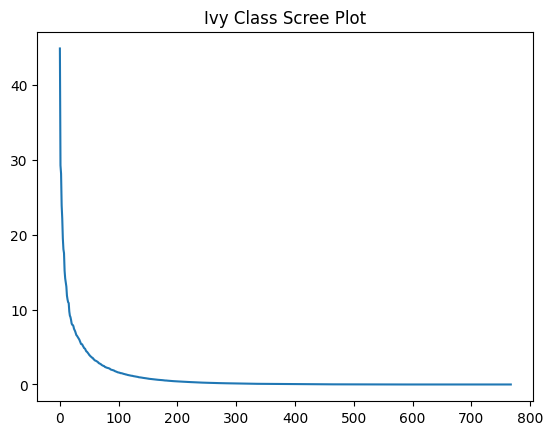

In [10]:
eigenvaluePCA(class_cloud, "Class")

In [ ]:
eigenvaluePCA(method_cloud, 'Method')

In [ ]:
eigenvaluePCA(token_cloud,'Token')

Principle Componenet Analysis: Use Sklearn PCA to determine feature importace/dimensionality. That is, we can find the number of components that explain P% of the variance

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def sklearnPCA(embedding_cloud, threshold, title):
    '''
    PCA:
    1.) standardize the data
    2.) transform data with PCA
    3.) transform explained variance ratio list to a cumulative explained variance list
    4.) Use cumulative explained variance to determine how many components account for threshold% of total variance
    5.) plot Principle components on a line graph in decreasing order by explained variance ratio
    '''
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(embedding_cloud)

    pca = PCA()
    pca.fit(data_standardized)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


    #returns shortened list of components where the list accounts for 95% of the total variance
    principle_components = np.argmax(cumulative_variance >= threshold) + 1
    print(principle_components)

    # Plot the principle components
    plt.plot(cumulative_variance)
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.title('Scikit-learn PCA on Ivy '+title)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()

193


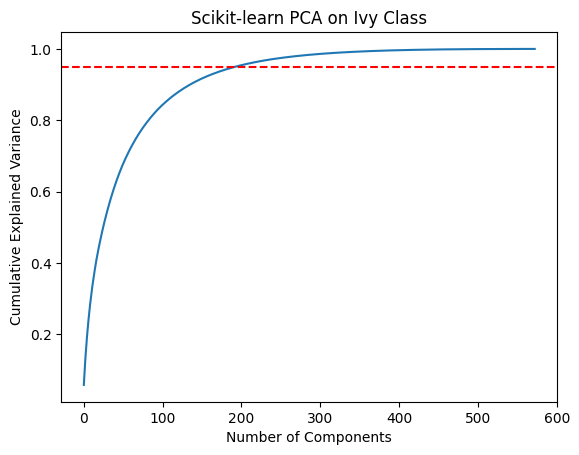

In [12]:
sklearnPCA(class_cloud, .95, "Class")

In [ ]:
sklearnPCA(method_cloud, 'Method')

In [ ]:
sklearnPCA(token_cloud,'Token')

Data Visualization:

PCA: Linear dimensionality reduction tool. PCA is used to transform the data and visualize in 2D

In [13]:
def visualPCA(embedding_cloud, title):
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(embedding_cloud)

    pca = PCA(n_components=2)
    principle_components = pca.fit_transform(data_standardized)

    plt.scatter(principle_components[:, 0], principle_components[:, 1], alpha=0.7)
    plt.title('PCA Visualization for Ivy'+title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

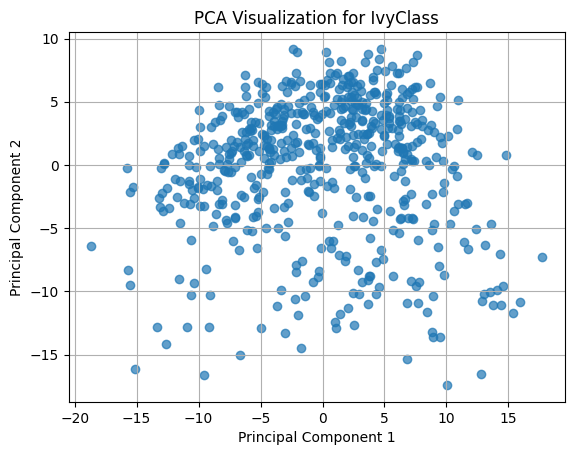

In [14]:
visualPCA(class_cloud,'Class')

In [ ]:
visualPCA(method_cloud, 'Method')

In [ ]:
visualPCA(token_cloud,'Token')

UMAP: Non Linear dimensionality reduction tool

In [15]:
import umap

def visualUMAP(embedding_cloud,title):
    reducer = umap.UMAP(n_components=2, random_state=42)
    umap_result = reducer.fit_transform(embedding_cloud)
    plt.scatter(umap_result[:, 0], umap_result[:, 1])
    plt.title("UMAP Visualization for Ivy " + title )
    plt.show()

c:\Users\gbrow\Code\python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\gbrow\Code\python\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gbrow\Code\python\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


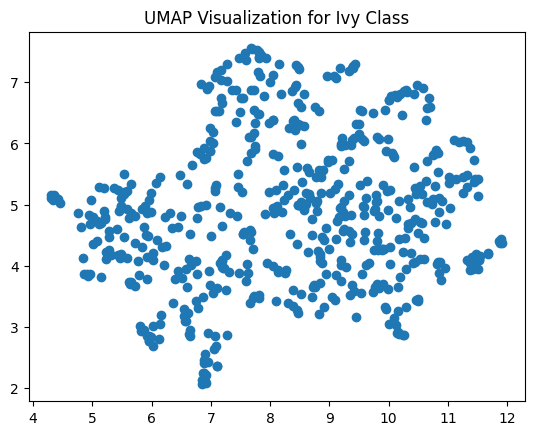

In [16]:
visualUMAP(class_cloud, 'Class')

In [ ]:
visualUMAP(method_cloud,'Method')

In [ ]:
visualUMAP(token_cloud,'Token')

T-SNE: Another nonlinear data visualization tool. Computationally expensive so only used for Class and Method

In [ ]:
from sklearn.manifold import TSNE

def visualTSNE(embedding_cloud,title):
    tsne = TSNE(n_components=3, random_state=42)
    reduced_data = tsne.fit_transform(np.array(class_cloud))

    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.7)
    plt.title("t-SNE Visualization of Ivy "+ title)
    plt.show()


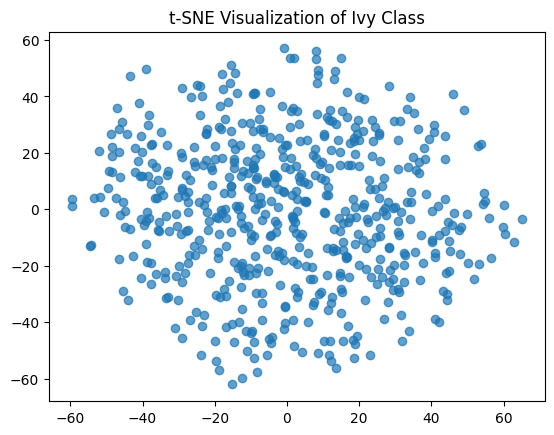

In [ ]:
visualTSNE(class_cloud,'Class')

In [ ]:
visualTSNE(method_cloud,'Method')

3.) Get a feel for spacing by computing the pairwise distances between embeddings (perhaps as a histogram) to understand how dense the embeddings are (in a Euclidean sense)

In [19]:
def computePairwiseDistances(embedding_cloud, title):
  '''
  Pairwise Distances (very inefficient O(n^2))
  1.) for each embedding, calculate the average distance to all other embeddings using l2-norm
  2.) add them to a list
  3.) plot the list on a histogram
  '''
  distances = []
  for i in range(len(embedding_cloud)):
    avg_distance = 0
    for j in range(len(embedding_cloud)):
      if i != j:
        distance = np.linalg.norm(np.array(embedding_cloud[i]) - np.array(embedding_cloud[j]))
        avg_distance += distance
    avg_distance /= len(embedding_cloud) - 1
    distances.append(avg_distance)
  
  avg = np.mean(distances)
  std = np.std(distances)

  plt.hist(distances, bins = round(len(embedding_cloud)/2), histtype='step', color=['blue'], fill=True, alpha=0.05)
  plt.axvline(avg, color='k', linestyle='dashed', linewidth=1)
  plt.axvline(avg+std, color='red', linestyle='dashed', linewidth=1)
  plt.axvline(avg-std, color='red', linestyle='dashed', linewidth=1)
  plt.xlabel('Pairwise Distance')
  plt.ylabel('Frequency')
  plt.title('Ivy ' + title + ' Pairwise Distance Histogram')

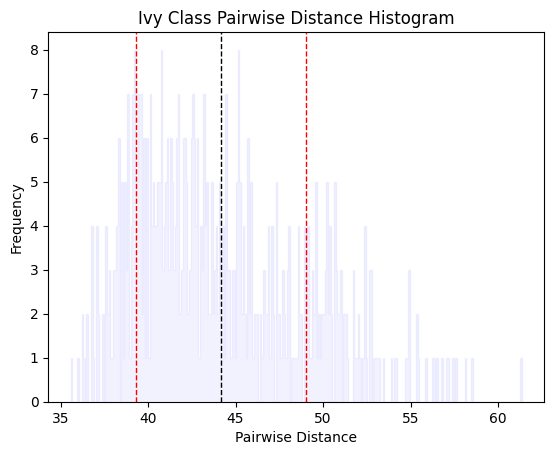

In [20]:
computePairwiseDistances(class_cloud, 'Class')

In [ ]:
computePairwiseDistances(method_cloud,'Method')

In [ ]:
computePairwiseDistances(token_cloud,'Token')

Hierarchy clustering Analysis

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import networkx as nx

def hierarchyClustering(embedding_cloud, title):
    '''
    Hierarchal Clustering Analysis
    1.) make linkage that encodes tree associated with embedding clouse
    2.) use this linkage to make a dendrogram that visualizes tree, color coding significant clusters
    '''
    linked = linkage(embedding_cloud, method='ward')
    dendrogram(linked)
    plt.title("Hierarchy Clustering Analysis for Ivy "+title)
    plt.show()  


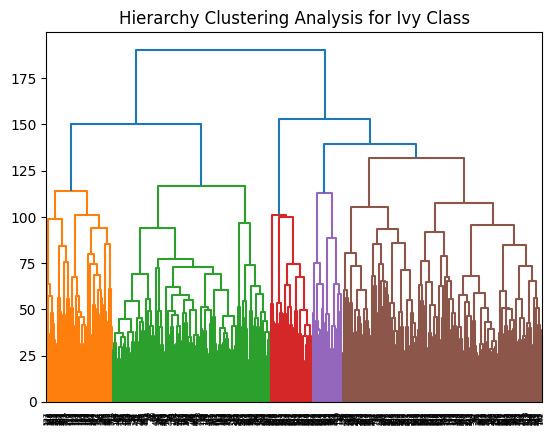

In [22]:
hierarchyClustering(class_cloud,'Class')


In [ ]:
hierarchyClustering(method_cloud,'Method')

In [ ]:
hierarchyClustering(token_cloud,'Token')

4.) There is also dynamism to assess. A lexical element can move depending on the context, so how much do they move?